# <div align="center">Dew Point and Thermal Comfort</div>
This notebook is a __compilation of publicly available information__ and open access scientific articles __related to human thermal comfort__ in hot and humid conditions. The Python™ code developed for this notebook calculates the dew point for local conditions and determines the categories of human thermal comfort assigned to these parameters.

**Summary:** A __figure__ at the end of this notebook (Step 6) showing the relationship between dew point, air temperature, and relative humidity with comfort categories.

---

## <div align="center">Calculation of the dew point as a function of air temperature and relative humidity</div>
The __dew point is often used as an indicator for thermal comfort__ of humans, however, thermal comfort depends on many factors [(e.g., Wikipedia and references therein)](https://en.wikipedia.org/wiki/Thermal_comfort#Interplay_of_temperature_and_humidity).
The dew point is the temperature $T_{d}$ at which air becomes fully saturated with moisture. The dew point can be calculated from the air temperature $T$ (in °C) and the relative humidity $RH$ (in percent) using [empirical approximations](https://en.wikipedia.org/wiki/Heat_index#Formula) [(Lawrence, 2005)](https://doi.org/10.1175/BAMS-86-2-225) summarized in an [Wikipedia article](https://en.wikipedia.org/wiki/Dew_point) about the meteorological dew point:

$$
\begin{align}
\gamma(T,RH) = ln(\frac{RH} {100})  +  \frac{b T} {c + T}\tag{1}
\end{align}
$$
$$
\begin{align}
T_d = \frac{c \gamma(T,RH)} {b - \gamma(T,RH)} \tag{2}
\end{align}
$$

where $b = 17.625$ and $c = 243.04$ minimize the maximum deviation over the range −40 °C to +50 °C [(Wikipedia)](https://en.wikipedia.org/wiki/Heat_index#Formula).   

**NOTE:** this code uses the [MetPy](https://pypi.org/project/MetPy) library [(May et al., 2022)](https://doi.org/10.1175/BAMS-D-21-0125.1) if it is installed and the empirical approximations from above as fallback. The differences in calculated dew point temperatures between the two approaches is generally very small (< 0.1 °C) and can be neglected. 

### Step 1: Load required packages and set up parameters for plotting

In [1]:
# import required modules
import numpy as np
from   matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patheffects as fx

# if MetPy is installed use it to calculate the dew point. alternatively, use the empirical approximation from equation (2) above.
try:
    from metpy.units import units
    from metpy.calc  import dewpoint_from_relative_humidity
    METHOD = 'METPY'
except ImportError:
    print("To install MetPy see: https://unidata.github.io/MetPy/latest/userguide/installguide.html")
    METHOD = 'EMPIRICAL'

# set font size for all plots
font_size = 20
plt.rcParams['xtick.labelsize'] = 0.75*font_size
plt.rcParams['ytick.labelsize'] = 0.75*font_size

# set font to Arial for all objects
plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

# avoid italics in some older Python™ versions 
plt.rcParams['mathtext.default'] = 'regular'

# set font size for axis labels
plt.rcParams['axes.labelsize'] = font_size

# increase spacing between axis tick marks and tick labels
plt.rcParams['xtick.major.pad']='6'
plt.rcParams['ytick.major.pad']='6'

### Step 2: Define temperature ranges for human comfort categories

In [2]:
# define temperature ranges for human comfort categories
"""
- Below 55°F (13°C): The air feels dry and comfortable.
- 55–60°F (13–16°C): Still fairly pleasant for most people.
- 60–65°F (16–18°C): Starting to feel a bit muggy.
- 65–70°F (18–21°C): Uncomfortable for many—sweat doesn’t evaporate easily.
- Above 70°F (21°C): Oppressive. The air feels heavy, sticky, and it’s hard for your body to cool down.
"""
categories_celsius    = ['<13°C','13-16°C','16-18°C','18-21°C','>21°C']
categories_fahrenheit = ['<55°F','55-60°F','60-65°F','65-70°F','>70°F']
categories_comfort    = ['comfortable','pleasant','muggy','uncomfortable','oppressive']

### Step 3: Helper functions for various calculations

In [3]:
# helper functions to convert Celsius to Fahrenheit and vice versa in case MetPy is not installed
def C2F(T):
    return T*1.8 + 32
def F2C(Tf):
    return ((Tf - 32) * 5)/9

# function for dew point calculation
def calc_dew_point(t, rh):
    b  = 17.625
    c  = 243.04
    gamma = np.log(rh/100) + b*t/(c + t) 
    dp = c*gamma/(b-gamma) # dew point in °C as function of RH in percent and T in °C
    return dp

### Step 4: Calculate dew points over a range of temperatures and relative humidity

In [4]:
# calculate matrix of dew points over a range of temperatures and relative humidity
"""
    For Washington, DC, the monthly average relative humidity is:
        - June:      68%
        - July:      69%
        - August:    71% 
        - September: 72%
    Use a range from 40% to 95% to cover daily minima and maxima.
"""

t     = np.linspace(0.0,  40.0, num=401)  # temperature from 0°C to 40°C in 0.1°C increments
rh    = np.linspace(40.0, 95.0, num=551)  # relative humidity in percent in 0.1% increments
T, RH = np.meshgrid(t, rh, indexing='ij') # using matrix indexing (not the default)

# calculate dew points over a range of temperatures and relative humidity
if METHOD == 'EMPIRICAL':
    dp_c = calc_dew_point(T, RH)
    dp_f = C2F(dp_c) # convert dew point matrix in Celsius to Fahrenheit
elif METHOD == 'METPY':
    dp_c = dewpoint_from_relative_humidity(T*units.degC, RH*units.percent)
    dp_f = dp_c.to('degF') # convert dew point matrix in Celsius to Fahrenheit

### Step 5: Set parameters for contour plotting 

In [5]:
# dew point in Celsius
norm_c   = cm.colors.Normalize(vmin=-12.5, vmax=41)
cmap_c   = cm.plasma
levels_c = np.arange(-12.0, 42.0, 2.0)

# dew points in Fahrenheit
norm_f   = cm.colors.Normalize(vmin=10, vmax=110)
cmap_f   = cm.YlGnBu_r
levels_f = np.arange(10, 110, 5)

## Step 6: Plot dew point as a function of temperature and relative humidity with comfort categories

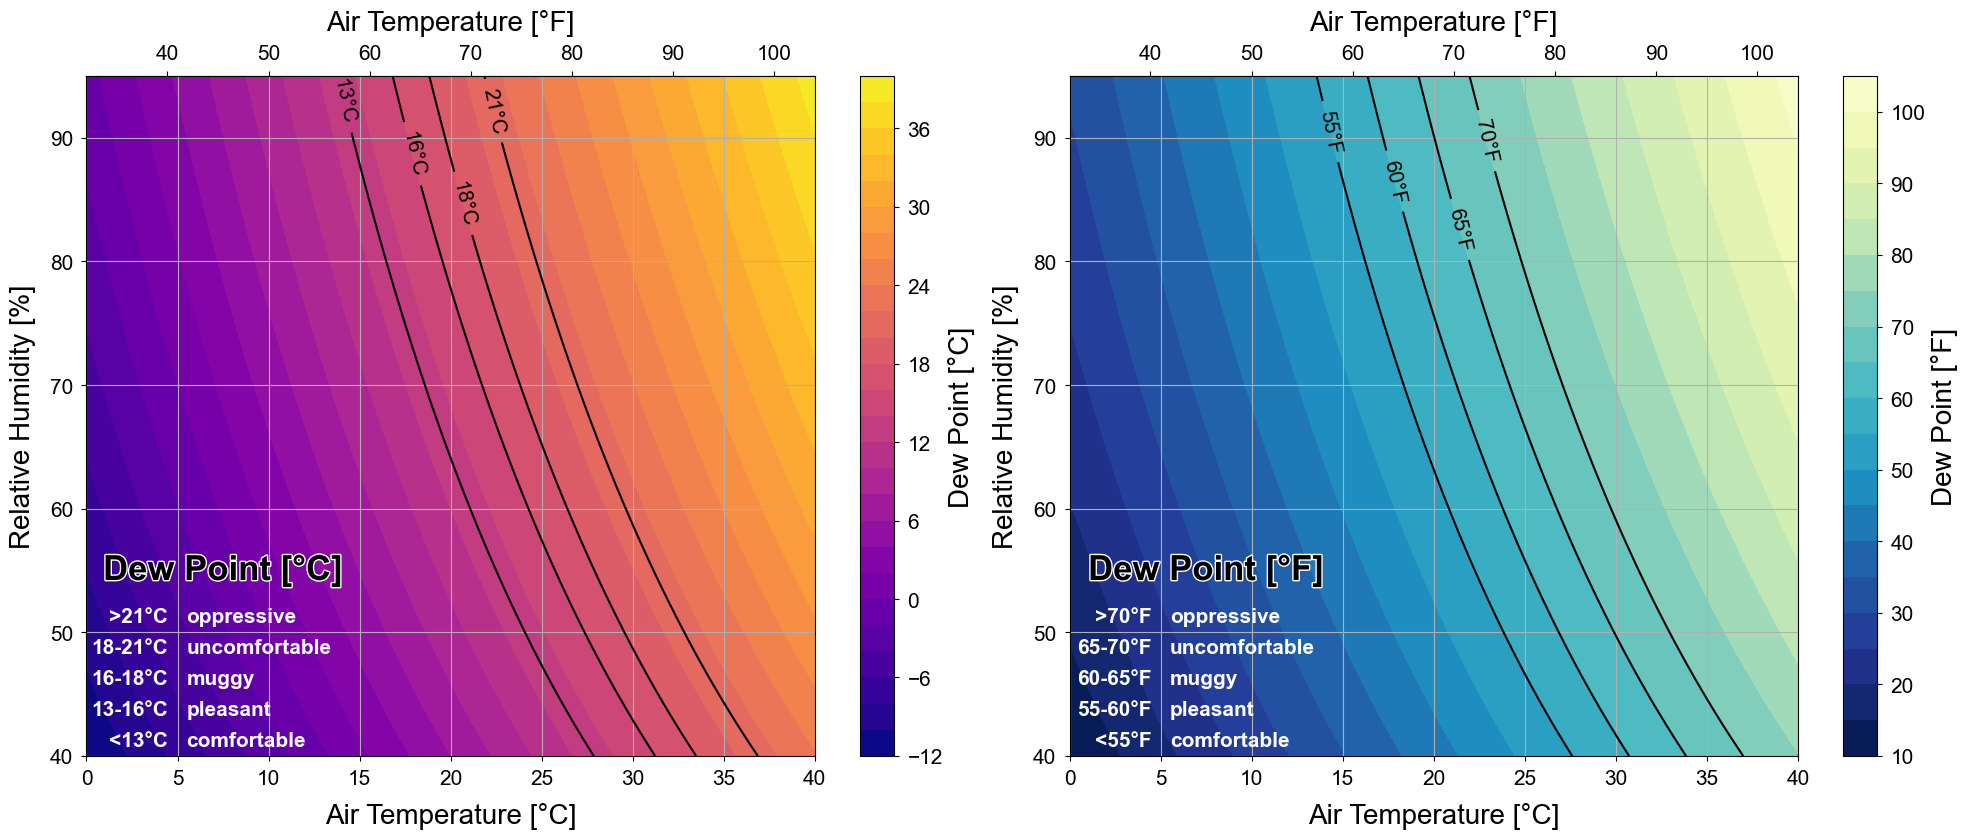

In [6]:
fig, (ax1,ax2) = plt.subplots(1, 2, squeeze=True, sharey = False, figsize = (20,8.5), tight_layout = True)

# left panel - dew point in Celsius
im1 = ax1.contourf(T, RH, dp_c,levels_c,norm=norm_c, cmap=cmap_c.resampled(len(levels_c)))
fig.colorbar(im1, ax=ax1, label='Dew Point [°C]')
ax1.set_xlabel('Air Temperature [°C]',fontsize = font_size, labelpad=10)
ax1.set_ylabel('Relative Humidity [%]',fontsize = font_size, labelpad=10)
secax_x = ax1.secondary_xaxis('top', functions=(C2F, F2C))
secax_x.set_xlabel('Air Temperature [°F]',fontsize = font_size, labelpad=10)
ax1.grid(True)

# right panel - dew point in Fahrenheit
im2 = ax2.contourf(T, RH, dp_f,levels_f,norm=norm_f, cmap=cmap_f.resampled(len(levels_f)))
fig.colorbar(im2, ax=ax2, label='Dew Point [°F]') #, shrink = 0.185)
ax2.set_xlabel('Air Temperature [°C]',fontsize = font_size, labelpad=10)
ax2.set_ylabel('Relative Humidity [%]',fontsize = font_size, labelpad=10)
secax_x = ax2.secondary_xaxis('top', functions=(C2F, F2C))
secax_x.set_xlabel('Air Temperature [°F]',fontsize = font_size, labelpad=10)
ax2.grid(True)

# add comfort level in both panels
rh_start = 41.250
rh_incrm = 2.50
for i in range(len(categories_celsius)):
    ax1.text(4.5,rh_start + i*rh_incrm,categories_celsius[i],   ha="right",va='center',color = 'w', fontsize = 0.75*font_size, fontweight = 'bold')
    ax1.text(5.5,rh_start + i*rh_incrm,categories_comfort[i],   ha="left", va='center',color = 'w', fontsize = 0.75*font_size, fontweight = 'bold')
    ax2.text(4.5,rh_start + i*rh_incrm,categories_fahrenheit[i],ha="right",va='center',color = 'w', fontsize = 0.75*font_size, fontweight = 'bold')
    ax2.text(5.5,rh_start + i*rh_incrm,categories_comfort[i],   ha="left", va='center',color = 'w', fontsize = 0.75*font_size, fontweight = 'bold')
    
# plot contours with custom labels for comfort levels    
def fmt_c(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s}°C"
    
def fmt_f(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s}°F"

# plot contours of interest for human comfort level
CS1 = ax1.contour(T, RH, dp_c,colors='k',levels = [13,16,18,21])
ax1.clabel(CS1, CS1.levels, fmt=fmt_c, fontsize=0.75*font_size, inline_spacing=8)    

CS2 = ax2.contour(T, RH, dp_f,colors='k',levels = [55,60,65,70])
ax2.clabel(CS2, CS2.levels, fmt=fmt_f, fontsize=0.75*font_size, inline_spacing=8) 

# plot panel "titles"
h1 = ax1.text(7.5,55,"Dew Point [°C]",ha="center",va='center',color = 'k', fontsize = 1.25*font_size, fontweight = 'bold')
h1.set_path_effects([fx.Stroke(linewidth=2.0, foreground='1.0'),fx.Normal()])
h2 = ax2.text(7.5,55,"Dew Point [°F]",ha="center",va='center',color = 'k', fontsize = 1.25*font_size, fontweight = 'bold')
h2.set_path_effects([fx.Stroke(linewidth=2.0, foreground='1.0'),fx.Normal()])     

### References
- Dew point: https://en.wikipedia.org/wiki/Dew_point
- Lawrence, M. G.: The Relationship between Relative Humidity and the Dewpoint Temperature in Moist Air: A Simple Conversion and Applications, Bull. Amer. Meteor. Soc., 86, 225–234, https://doi.org/10.1175/BAMS-86-2-225, 2005.
- May, R. M., Goebbert, K. H., Thielen, J. E., Leeman, J. R., Camron, M. D., Bruick, Z., Bruning, E. C., Manser, R. P., Arms, S. C., and Marsh, P. T., 2022: MetPy: A Meteorological Python Library for Data Analysis and Visualization. Bull. Amer. Meteor. Soc., 103, E2273-E2284, https://doi.org/10.1175/BAMS-D-21-0125.1.